In [1]:
from __future__ import division
from boxtask_func import *
from MDPclass import *
from oneboxCol import *

In [2]:
import numpy as np
from scipy.stats import binom
from scipy.integrate import quad
import matplotlib.pyplot as plt

from scipy.linalg import toeplitz, expm
from scipy import optimize
from math import sqrt
from scipy.stats import norm

In [3]:
import matplotlib as mpl
# pdf.fontype and ps.fontype must be set to 42 in order for text in exported figure to be editable in Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# transition probability

In [4]:
p_appear = 0.2
p_disappear = 0.05

In [5]:
nq = 5 # number of belief states per box
nr = 2  # number of reward states
na = 2

In [6]:
NumCol = 4
qmin = 0.3
qmax = 0.7
Ncol = NumCol - 1



In [11]:
Trans_state = np.array([[1-p_appear, p_disappear], 
                        [p_appear, 1-p_disappear]])
Obs_emis = np.zeros((Ncol + 1, 2))    #Observation(color) generation
Obs_emis[:, 0] = binom.pmf(range(Ncol + 1),Ncol,qmax)
Obs_emis[:, 1] = binom.pmf(range(Ncol + 1),Ncol,qmin)

In [12]:
belief_old = np.arange(0, 1, 0.01)
N = len(belief_old)

beliefupdate = Trans_state.dot(np.array([1-belief_old, belief_old]))
belief_new = beliefupdate[1, :]
ObsPro = Obs_emis.dot(beliefupdate)
belief_new_obs = np.outer(Obs_emis[:, 1], belief_new) / ObsPro

In [13]:
def gb(x, k1, k0, p_appear, p_disappear):
    a = 1 - p_disappear - p_appear
    return (k1*a*x + k1*p_appear)/((k1-k0)*a*x + k1*p_appear + k0*(1-p_appear))

In [14]:
def gbinv(y, k1, k0, p_appear, p_disappear):
    a = 1 - p_disappear - p_appear
    return (y * (k1*p_appear + k0*(1-p_appear)) - k1*p_appear) / (k1*a - y*(k1-k0)*a)

In [15]:
dq = 1/nq
#a = 1 - p_disappear - p_appear

Trans_belief_obs = np.zeros((Ncol + 1, nq,nq))

d = np.zeros((Ncol + 1, nq, nq))
den = np.zeros((Ncol + 1, nq, nq))
xopt = np.zeros((Ncol + 1, nq, nq))
height = np.zeros((Ncol + 1, nq, nq))
Trans_belief_obs_approx = np.zeros((Ncol + 1, nq,nq))

for n in range(Ncol + 1):
    k0 = Obs_emis[n, 0]
    k1 = Obs_emis[n, 1]
    
    for i in range(nq):
        for j in range(nq):
            xmin = dq*i
            xmax = dq*(i+1)
            ymin = dq*j
            ymax = dq*(j+1)
            
            bl = max(gbinv(ymin, k1, k0, p_appear, p_disappear), xmin)
            br = min(gbinv(ymax, k1, k0, p_appear, p_disappear), xmax)
            
            if bl > br:
                Trans_belief_obs[n, j, i] = 0
            else:
                Trans_belief_obs[n, j, i] = quad(lambda x: Obs_emis[n, :].dot(Trans_state).dot(np.array([1-x, x])), 
                                           bl, br)[0]
            
            
            # Approximate the probability with Gaussian approxiamtion
            q = i * dq + dq / 2
            qq = j * dq + dq / 2
            
            def dist(x):
                return sqrt((q - x)** 2 + (qq - gb(x, k1, k0, p_appear, p_disappear))**2)
            
            xopt[n, j, i], d[n, j, i] = optimize.fminbound(dist,0, 1, full_output=1)[0:2]
            den[n, j, i] = norm.pdf(d[n, j, i], 0, 1/nq/3)
            height[n, j, i] = Obs_emis[n, :].dot(Trans_state).dot(np.array([1-xopt[n, j, i], xopt[n, j, i]]))

    den[n] = den[n] / np.tile(np.sum(den[n], 0), (nq, 1))
    Trans_belief_obs_approx[n] = np.multiply(den[n], height[n])
            

In [16]:
Trans_belief = np.sum(Trans_belief_obs, axis = 0)
Trans_belief = Trans_belief / np.tile(np.sum(Trans_belief, 0), (nq, 1))

nt = 20
d = 0.1 / nt
dD = toeplitz(np.insert(np.zeros(nq - 2), 0, np.array([-2 * d, d])))
dD[1, 0] = 2 * d
dD[-2, -1] = 2 * d
D = expm(dD * nt)
D = D / np.tile(np.sum(D, 0), (nq, 1))
Trans_belief1 = np.dot(D, Trans_belief)

Trans_belief_approx = np.sum(Trans_belief_obs_approx, axis = 0)
Trans_belief_approx = Trans_belief_approx / np.tile(np.sum(Trans_belief_approx, 0), (nq, 1))

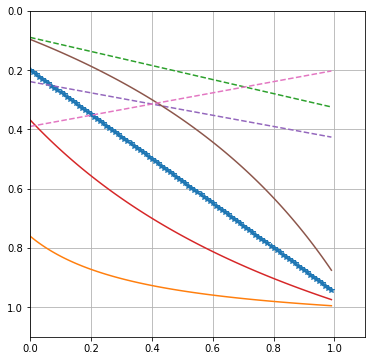

In [17]:
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(belief_old, belief_new, '-*')
for i in range(Ncol):
    plt.plot(belief_old, belief_new_obs[i, :])
    plt.plot(belief_old, ObsPro[i, :], '--')
ax.set_ylim([0,1.1])
ax.set_xlim([0,1.1])
ax.xaxis.set_ticks(np.arange(0, 1.1, 1/nq))
ax.yaxis.set_ticks(np.arange(0, 1.1, 1/nq))
plt.grid()
plt.gca().invert_yaxis()
plt.show()

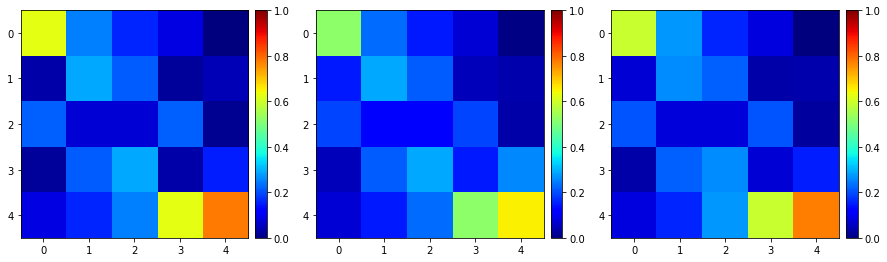

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize = (15, 60))
#fig.subplots_adjust(wspace=0,hspace=0)

ax1 = fig.add_subplot(1,3,1)
im1 = ax1.imshow(Trans_belief, vmin=0, vmax=1, cmap='jet')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(1,3,2)
im2 = ax2.imshow(Trans_belief1, vmin=0, vmax=1, cmap='jet')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')


ax3 = fig.add_subplot(1,3,3)
im3 = ax3.imshow(Trans_belief_approx, vmin=0, vmax=1, cmap='jet')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im3, cax=cax, orientation='vertical')

plt.show()

# One box MDP

In [7]:
nq = 5
nr = 2
na = 2
discount = 0.99

In [8]:
beta = 0   # available food dropped back into box after button press
gamma = 0.3    # reward becomes available
epsilon = 0.1   # available food disappears
rho = 1    # food in mouth is consumed
pushButtonCost = 0.6
Reward = 1
NumCol = 4
qmin = 0.3
qmax = 0.7
Ncol = NumCol - 1

parameters = [beta, gamma, epsilon, rho, pushButtonCost, 
              NumCol, qmin, qmax]


In [9]:
oneboxCol = oneboxColMDP(discount, nq, nr, na, parameters)

In [10]:
oneboxCol.setupMDP()
oneboxCol.solveMDP_sfm()
oneboxCol.softpolicy

array([[0.98720315, 0.93767601, 0.82003143, 0.49267086, 0.21245447,
        0.98720315, 0.93767601, 0.82003143, 0.49267086, 0.21245447],
       [0.01279685, 0.06232399, 0.17996857, 0.50732914, 0.78754553,
        0.01279685, 0.06232399, 0.17996857, 0.50732914, 0.78754553]])

# Generate data

In [12]:
T = 1000
N = 1
hiddenInitial = 0
obsInitial = 0

In [13]:
oneboxColdata = oneboxColMDPdata(discount, nq, nr, na, parameters, T, N)
oneboxColdata.dataGenerate_sfm(hiddenInitial, obsInitial)   #softmax policy

belief = oneboxColdata.belief
action = oneboxColdata.action
reward = oneboxColdata.reward
hybrid = oneboxColdata.hybrid
trueState = oneboxColdata.trueState
color = oneboxColdata.color

In [14]:
obsN = np.dstack([action, reward, color])
latN = belief.copy()

## Store data

In [ ]:
from datetime import datetime
import pickle

In [ ]:
# # sampleNum * sampleTime * dim of observations(=3 here, action, reward, location)
# # organize data

# datestring = datetime.strftime(datetime.now(), '%m%d%Y(%H%M)')

# obsN = np.dstack([action, reward, color])  # includes the action and the observable states
# latN = np.dstack([belief])
# truthN = np.dstack([trueState])
# dataN = np.dstack([obsN, latN, truthN])

# ### write data to file
# data_dict = {'observations': obsN,
#              'beliefs': latN,
#              'trueStates': truthN,
#              'allData': dataN}
# data_output = open(datestring + '_dataN_twobox' + '.pkl', 'wb')
# pickle.dump(data_dict, data_output)
# data_output.close()

# ### write all model parameters to file
# para_dict = {'discount': discount,
#              'nq': nq,
#              'nr': nr,
#              'na': na,
#              'foodDrop': beta,
#              'appRate': gamma,
#              'disappRate': epsilon,
#              'consume': rho,
#              'reward': Reward,
#              'pushButtonCost': pushButtonCost
#              }
# para_output = open(datestring + '_para_twobox' + '.pkl', 'wb')
# pickle.dump(para_dict, para_output)
# para_output.close()

# pkl_file1 = open(datestring + '_para_twobox' + '.pkl', 'rb')
# para_pkl = pickle.load(pkl_file1)
# pkl_file1.close()
# #print(para_pkl['disappRate2'])

# print('Data stored in files' )

## retrieve data

In [ ]:
import os
path = os.getcwd()

In [ ]:
pkl_file = open(path + '/11152018(1102)_dataN_twobox.pkl', 'rb')
pkl_file1 = open(path + '/11152018(1102)_para_twobox.pkl', 'rb')

In [ ]:
para_pkl = pickle.load(pkl_file1)
pkl_file1.close()
para_pkl.keys()

In [ ]:
discount = para_pkl['discount']
nq = para_pkl['nq']
nr = para_pkl['nr']
na = para_pkl['na']
beta = para_pkl['foodDrop']
gamma = para_pkl['appRate']
epsilon = para_pkl['disappRate']
rho = para_pkl['consume']
Reward = para_pkl['reward']
pushButtonCost = para_pkl['pushButtonCost']

In [ ]:
print("Get data from file...")
dataN_pkl = pickle.load(pkl_file)
pkl_file.close()

obsN = dataN_pkl['observations']
latN = dataN_pkl['beliefs']
truthN = dataN_pkl['trueStates']
dataN = dataN_pkl['allData']

In [ ]:
obs = obsN[0]
lat = latN[0]

In [ ]:
T = np.shape(obsN)[1]

action, reward, color = obsN[0:, :, 0], obsN[0:, :, 1], obsN[0:, :, 2]
belief = latN[:, :, 0]
trueState = truthN[:, :, 0]

hybrid = reward * nq + belief

## show data

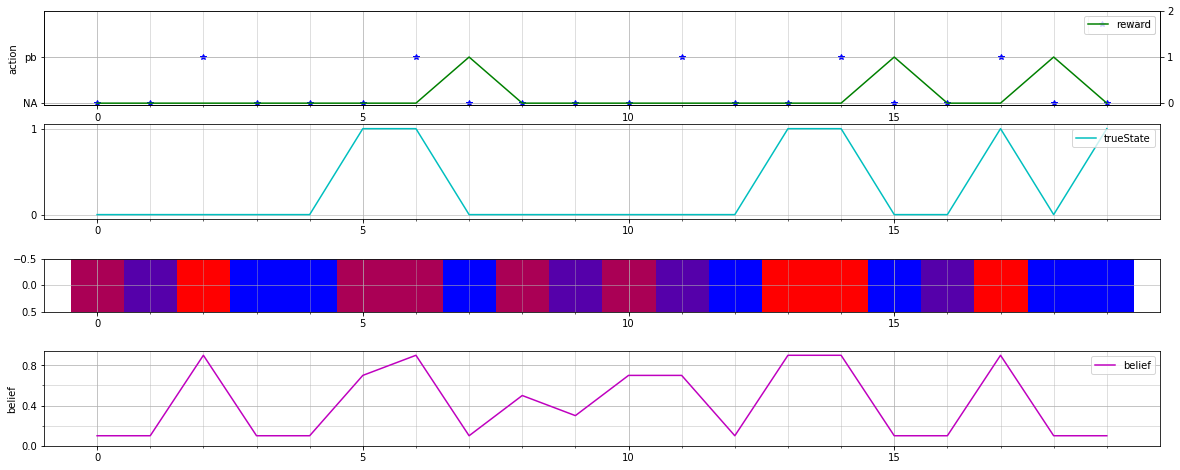

In [15]:
showTime = 20

data_true = np.reshape(trueState[0, 0:showTime], showTime)
data_action = np.reshape(action[0, 0:showTime], showTime)
data_reward = np.reshape(reward[0, 0:showTime], showTime)
data_belief = np.reshape((belief[0, 0:showTime] + 1 / 2) / float(nq), showTime)
data_hybrid = np.reshape(hybrid[0, 0:showTime], showTime)
data_color = np.reshape(color[0, 0:showTime], showTime)

# colorvalue = qmin + (qmax - qmin) / Ncol * data_color
# colorvalue.reshape((1, colorvalue.shape[0]))
# colormapR = (qmax - colorvalue) / (qmax - qmin) * 255
# colormapG = np.zeros(np.shape(colorvalue))
# colormapB = (colorvalue - qmin) / (qmax - qmin) * 255
colormapR = (Ncol - data_color)* 255 / Ncol
colormapG = np.zeros(np.shape(data_color))
colormapB = data_color * 255 / Ncol
colorimage = np.dstack((colormapR, colormapG, colormapB))
colorImageShow = np.array(colorimage, dtype=np.uint8)

actiontemp = data_action * (1 * (data_action % pb == 0)) / pb

time = np.arange(0, showTime, 1)

#if sampleTime < 1000:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(411)
ax3 = fig.add_subplot(412)
ax4 = fig.add_subplot(413)
ax5 = fig.add_subplot(414)

ax1.plot(time, actiontemp, 'b*', label='action')
ax1.legend(loc=1)
ax1.set_xticks(np.arange(0, showTime, 5))
ax1.set_xticks(np.arange(0, showTime, 1), minor=True)
ax1.set_yticks(np.arange(0, 3, 1))
a = ax1.get_yticks().tolist()
a[0] = 'NA'
a[1] = 'pb'
ax1.set_yticklabels(a)
ax1.set_yticks(ax1.get_yticks()[0:2])
ax1.set_xlim(-1, showTime)
ax1.grid(which='minor', alpha=0.5)
ax1.grid(which='major', alpha=0.7)
ax1.set_ylabel('action')

ax2 = ax1.twinx()
ax2.plot(time, data_reward, 'g', label='reward')
ax2.legend(loc=1)
ax2.set_xticks(np.arange(0, showTime, 5))
ax2.set_xticks(np.arange(0, showTime, 1), minor=True)
ax2.set_yticks(np.arange(0, 3, 1))
ax2.grid(which='minor', alpha=0.5)
ax2.grid(which='major', alpha=0.7)

ax3.plot(time, data_true, 'c', label='trueState')
ax3.set_xlim(-1, showTime)
ax3.legend(loc=1)
ax3.set_xticks(np.arange(0, showTime, 5))
ax3.set_xticks(np.arange(0, showTime, 1), minor=True)
ax3.set_yticks(np.arange(0, 1.2))
ax3.grid(which='minor', alpha=0.5)
ax3.grid(which='major', alpha=0.7)

ax4.imshow(colorImageShow, interpolation='none')
#ax4.legend(loc=1)
ax4.set_xlim(-1, showTime)
ax4.set_xticks(np.arange(0, showTime, 5))
ax4.set_xticks(np.arange(0, showTime, 1), minor=True)
#ax4.set_yticks(np.arange(0, Ncol + 1))
ax4.grid(which='minor', alpha=0.5)
ax4.grid(which='major', alpha=0.7)

ax5.plot(time, data_belief, 'm', label='belief')
ax5.set_xlim(-1, showTime)
ax5.legend(loc=1)
ax5.set_xticks(np.arange(0, showTime, 5))
ax5.set_xticks(np.arange(0, showTime, 1), minor=True)
ax5.set_yticks(np.arange(0, 1, 2 * 1 / float(nq)))
ax5.set_yticks(np.arange(0, 1, 1 / float(nq)), minor=True)
ax5.grid(which='minor', alpha=0.5)
ax5.grid(which='major', alpha=0.7)
ax5.set_ylabel('belief')

plt.show()

# Inference

In [16]:
from oneboxCol import *
from HMMoneboxCol import *

In [17]:
#parameters = [0, gamma, epsilon, 1, pushButtonCost, 4, 0.4, 0.6]
parameters = [beta, gamma, epsilon, rho, pushButtonCost, NumCol, qmin, qmax]
parameters

[0, 0.3, 0.1, 1, 0.6, 4, 0.3, 0.7]

In [18]:
obs = obsN[0]
lat = latN[0]

In [19]:
beta_ini = 0
gamma_ini = 0.5
epsilon_ini = 0.3
rho_ini = 1
pushButtonCost_ini = 0.3
NumCol_ini = NumCol
qmin_ini = 0.1
qmax_ini = 0.8

parameters_ini = [beta_ini, gamma_ini, epsilon_ini, rho_ini, pushButtonCost_ini, 
                  NumCol_ini, qmin_ini, qmax_ini]
parameters_old = np.copy(parameters_ini)

print("The true paramters are:               ", parameters )
print("The initial estimation parameters are:", parameters_ini) 
print ("Now starting with some initialized value of the parameters, we are going to use EM(G) " \
"algorithm for parameter estimation:")

The true paramters are:                [0, 0.3, 0.1, 1, 0.6, 4, 0.3, 0.7]
The initial estimation parameters are: [0, 0.5, 0.3, 1, 0.3, 4, 0.1, 0.8]
Now starting with some initialized value of the parameters, we are going to use EM(G) algorithm for parameter estimation:


In [37]:
import timeit

start = timeit.default_timer()

NN1 = 100  # iteration number for the EM algorithm
eps = 10 ** -6

para_old_traj = []
para_new_traj = []

log_likelihoods_old = []
log_likelihoods_new = []
log_likelihoods_com_old = []  # old posterior, old parameters
log_likelihoods_com_new = []  # old posterior, new parameters
latent_entropies = []

count_E = 0
while count_E < NN1:

    print('\nThe', count_E, '-th iteration of the EM(G) algorithm')

    if count_E == 0:
        parameters_old = np.array(parameters_ini)
    else:
        parameters_old = np.copy(parameters_new)  # update parameters

    para_old_traj.append(parameters_old)
    print(parameters_old)

    ##########  E-step ##########

    ## Use old parameters to estimate posterior
    oneboxColder = oneboxColMDPder(discount, nq, nr, na, parameters_old)
    ThA_old = oneboxColder.ThA
    softpolicy_old = oneboxColder.softpolicy
    TBo_old = oneboxColder.Trans_hybrid_obs
    OE_TS_old = oneboxColder.Obs_emis_trans
    pi = np.ones(nq) / nq
    Ncol_old = parameters_old[5].astype(int) - 1
    oneHMMCol = HMMoneboxCol(ThA_old, softpolicy_old, TBo_old, OE_TS_old, pi, Ncol_old)

    ## Calculate likelihood of observed and complete date, and entropy of the latent sequence
    complete_likelihood_old = oneHMMCol.computeQaux(obs, ThA_old, softpolicy_old, TBo_old)
    latent_entropy = oneHMMCol.latent_entr(obs)
    log_likelihood = complete_likelihood_old + latent_entropy

    log_likelihoods_com_old.append(complete_likelihood_old)

    latent_entropies.append(latent_entropy)
    log_likelihoods_old.append(log_likelihood)

    print(complete_likelihood_old)
    print(log_likelihood)

    ## Check convergence
    if len(log_likelihoods_old) >= 2 and np.abs(log_likelihood - log_likelihoods_old[-2]) < eps:
        print('EM has converged!')
        break

    ##########  M(G)-step ##########
    
    count_M = 0
    M_thresh = 0.5
    para_new_traj.append([])
    log_likelihoods_com_new.append([])
    log_likelihoods_new.append([])
    stepsize = 2 * 10 ** -5

    # Start the gradient descent from the old parameters
    parameters_new = np.copy(parameters_old)
    complete_likelihood_new = complete_likelihood_old
    log_likelihood = complete_likelihood_new + latent_entropy

    para_new_traj[count_E].append(parameters_new)
    log_likelihoods_com_new[count_E].append(complete_likelihood_new)
    log_likelihoods_new[count_E].append(log_likelihood)

    print('\n M-step ')
    print(parameters_new)
    print(complete_likelihood_new)
    print(log_likelihood)

    while True:
        #print(np.array(oneboxColder.dQauxdpara_sim(obs, parameters_new)))
        ## Go the potential next point with gradient descent
        para_temp = parameters_new + stepsize * np.array(oneboxColder.dQauxdpara_sim(obs, parameters_new))
        #temp = np.copy(para_temp)
        #para_temp = np.copy(parameters_old)

        ## Check the ECDLL (old posterior, new parameters)
        onebox_new = oneboxColMDP(discount, nq, nr, na, para_temp)
        onebox_new.setupMDP()
        onebox_new.solveMDP_sfm()
        ThA_new = onebox_new.ThA
        softpolicy_new = onebox_new.softpolicy

        TBo_new = onebox_new.Trans_hybrid_obs
        OE_TS_new = onebox_new.Obs_emis_trans
        pi = np.ones(nq) / nq
        Ncol_new = para_temp[5] - 1
        oneHMMCol_new = HMMoneboxCol(ThA_new, softpolicy_new, TBo_old, OE_TS_new, pi, Ncol_new)

        complete_likelihood_new_temp = oneHMMCol.computeQaux(obs, ThA_new, softpolicy_new, TBo_new)

        ## Update the parameter if the ECDLL can be improved
        if complete_likelihood_new_temp > complete_likelihood_new + M_thresh:
            parameters_new = np.copy(para_temp)

            complete_likelihood_new = complete_likelihood_new_temp
            log_likelihood = complete_likelihood_new + latent_entropy

            para_new_traj[count_E].append(parameters_new)
            log_likelihoods_com_new[count_E].append(complete_likelihood_new)
            log_likelihoods_new[count_E].append(log_likelihood)

            print(parameters_new)
            print(complete_likelihood_new)
            print(log_likelihood)

            count_M += 1
            if count_M == 10:
                count_M = count_M / 2
            if count_M == 20:
                count_M = count_M / 2    
                
        else:
            stepsize /= 2
            if stepsize < 5 * 10 ** -6:
                break

    count_E += 1

print('end of EM')
stop = timeit.default_timer()


The 0 -th iteration of the EM(G) algorithm
[0.  0.5 0.3 1.  0.3 4.  0.1 0.8]
-3460.984331519019
-3379.806774979838

 M-step 
[0.  0.5 0.3 1.  0.3 4.  0.1 0.8]
-3460.984331519019
-3379.806774979838
[0.         0.31021047 0.24964329 1.         0.53850852 4.
 0.20697113 0.83151538]
-1973.7593746760813
-1892.5818181369002
[0.         0.29665935 0.26477258 1.         0.54170692 4.
 0.16443575 0.7856956 ]
-1767.737554937914
-1686.559998398733
[0.         0.31452552 0.27163246 1.         0.54443572 4.
 0.1614463  0.81457231]
-1741.512937169373
-1660.3353806301918
[0.         0.31237662 0.28201648 1.         0.54769912 4.
 0.13711443 0.79843891]
-1722.5211872738146
-1641.3436307346335
[0.         0.31973115 0.2824327  1.         0.54872348 4.
 0.14682461 0.81098434]
-1703.833783800267
-1622.6562272610859
[0.         0.32051677 0.28524719 1.         0.54994357 4.
 0.14334356 0.80765789]
-1699.3676214521818
-1618.1900649130007
[0.         0.32232665 0.28728946 1.         0.55106685 4.
 0.143107

[0.         0.33232641 0.27027426 1.         0.5772023  4.
 0.24612021 0.73541854]
-1714.6523950039418
-1486.582390926687

The 11 -th iteration of the EM(G) algorithm
[0.         0.33232641 0.27027426 1.         0.5772023  4.
 0.24612021 0.73541854]
-1724.5729527203146
-1485.065109119272

 M-step 
[0.         0.33232641 0.27027426 1.         0.5772023  4.
 0.24612021 0.73541854]
-1724.5729527203146
-1485.065109119272
[0.         0.33180729 0.2656939  1.         0.57777245 4.
 0.2523452  0.73311336]
-1722.947835893854
-1483.4399922928114

The 12 -th iteration of the EM(G) algorithm
[0.         0.33180729 0.2656939  1.         0.57777245 4.
 0.2523452  0.73311336]
-1731.0391346113558
-1482.3100286200863

 M-step 
[0.         0.33180729 0.2656939  1.         0.57777245 4.
 0.2523452  0.73311336]
-1731.0391346113558
-1482.3100286200863
[0.         0.33119862 0.26165727 1.         0.57860064 4.
 0.2572741  0.73116919]
-1729.8945618238931
-1481.1654558326236

The 13 -th iteration of the EM(G

In [38]:
parameters

[0, 0.3, 0.1, 1, 0.6, 4, 0.3, 0.7]

In [39]:
parameters_ini

[0, 0.5, 0.3, 1, 0.3, 4, 0.1, 0.8]

In [40]:
parameters_new

array([0.        , 0.32717503, 0.24565112, 1.        , 0.58374131,
       4.        , 0.27146606, 0.72333307])

### There is some problem here, since likelihood does not increase all the time

In [105]:
para1 = [0, 0.40069731, 0.09763441, 1, 0.62828816,  4, 0.25623033, 0.55046382]
para2 = [0, 0.40040587, 0.097499  , 1,  0.62795674, 4, 0.25629378, 0.55018447]

In [110]:
onebox1 = oneboxColMDPder(discount, nq, nr, na, para1)
ThA1 = onebox1.ThA
softpolicy1 = onebox1.softpolicy
TBo1 = onebox1.Trans_hybrid_obs
OE_TS1 = onebox1.Obs_emis_trans
pi = np.ones(nq) / nq
Ncol1 = para1[5] - 1
oneHMMCol1 = HMMoneboxCol(ThA1, softpolicy1, TBo1, OE_TS1, pi, Ncol1)

## Calculate likelihood of observed and complete date, and entropy of the latent sequence
complete_likelihood_old = oneHMMCol1.computeQaux(obs, ThA1, softpolicy1, TBo1)
latent_entropy = oneHMMCol1.latent_entr(obs)
log_likelihood = complete_likelihood_old + latent_entropy
print(log_likelihood)

-1495.8527317767575


In [114]:
oneHMMCol1.computeQaux(obs, ThA2, softpolicy2, TBo2) + oneHMMCol1.latent_entr(obs)

-1495.842751032063

In [140]:
onebox2 = oneboxColMDPder(discount, nq, nr, na, para2)
ThA2 = onebox2.ThA
softpolicy2 = onebox2.softpolicy
TBo2 = onebox2.Trans_hybrid_obs
OE_TS2 = onebox2.Obs_emis_trans
pi = np.ones(nq) / nq
Ncol2 = para2[5] - 1
oneHMMCol2 = HMMoneboxCol(ThA2, softpolicy2, TBo2, OE_TS2, pi, Ncol2)

## Calculate likelihood of observed and complete date, and entropy of the latent sequence
complete_likelihood_old = oneHMMCol2.computeQaux(obs, ThA2, softpolicy2, TBo2)
latent_entropy = oneHMMCol2.latent_entr(obs)
log_likelihood = complete_likelihood_old + latent_entropy
print(log_likelihood)

-1495.8499662643478


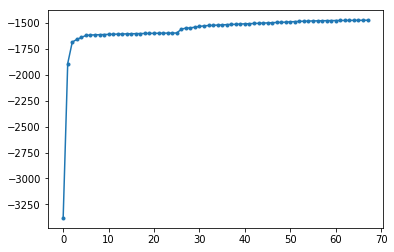

In [41]:
plt.plot([j for i in log_likelihoods_new for j in i], marker='.')
plt.show()

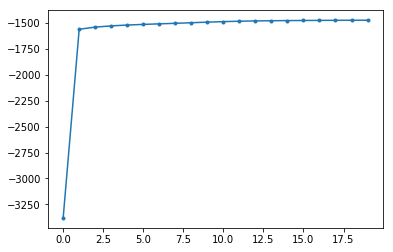

In [42]:
plt.plot([i for i in log_likelihoods_old], marker='.')
plt.show()

## Check Contour

In [43]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [44]:
L = len(para_old_traj) - 1

point = np.zeros((L, 8))
for i in range(L):
    point[i]  = para_old_traj[i + 1]

pca = PCA(n_components = 2)
pca.fit(point)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [45]:
projectionMat = pca.components_
print(projectionMat)
projectionMat = np.multiply(projectionMat, (np.abs(projectionMat) > 10** -10).astype(int))
projectionMat

[[-0.00000000e+00  1.11983339e-01  4.42001671e-01 -0.00000000e+00
  -1.02567719e-01 -0.00000000e+00 -7.68525246e-01  4.36970323e-01]
 [ 0.00000000e+00  3.82578114e-02 -8.15520258e-01 -2.77555756e-17
   3.79122039e-02  0.00000000e+00 -1.52583452e-01  5.55647374e-01]]


array([[-0.        ,  0.11198334,  0.44200167, -0.        , -0.10256772,
        -0.        , -0.76852525,  0.43697032],
       [ 0.        ,  0.03825781, -0.81552026, -0.        ,  0.0379122 ,
         0.        , -0.15258345,  0.55564737]])

In [ ]:
step1 = 0.01    # for u (1st principle component)
step2 = 0.01   # for v (2nd principle component)
N1 = 50
N2 = 50
uOffset = - step1 * N1 / 2 
vOffset = - step2 * N2 / 2

uValue = np.zeros(N1)
vValue = np.zeros(N2)
Qaux1 = np.zeros((N2, N1))    # Likelihood with ground truth latent
Qaux2 = np.zeros((N2, N1))    # Expected complete data likelihood
Qaux3 = np.zeros((N2, N1))    # Entropy of latent posterior
para_slice = []

for i in range(N1):
    uValue[i] = step1 * (i) + uOffset
    for j in range(N2):
        vValue[j] = step2 * (j) + vOffset

        #para_slicePoints = [0, uValue[i], 0.05, 1, 0.3, 3, vValue[j], 0.6]
        para_slicePoints = point[-1] + uValue[i] * projectionMat[0] + vValue[j] * projectionMat[1]
        #print(para_slicePoints)
        para_slice.append(para_slicePoints)
        para = np.copy(para_slicePoints)
        
        ####### Compute value for contour
        oneCol = oneboxColMDP(discount, nq, nr, na, para)
        oneCol.setupMDP()
        oneCol.solveMDP_sfm()
        #print(oneCol.Vsfm)
        ThA = oneCol.ThA
        policy = oneCol.softpolicy
        pi = np.ones(nq)/ nq  # initialize the estimation of the belief state
        TBo = oneCol.Trans_hybrid_obs
        OE_TS = oneCol.Obs_emis_trans
        oneColHMM = HMMoneboxCol(ThA, policy, TBo, OE_TS, pi, 3)
        
        #Qaux1[j, i] = twoboxHMM.likelihood(lat, obs, ThA, policy)  #given latent state
        Qaux2[j, i] = oneColHMM.computeQaux(obs, ThA, policy, TBo) 
        Qaux3[j, i] = oneColHMM.latent_entr(obs) 

In [ ]:
Loglikelihood = Qaux2 + Qaux3

In [ ]:
from matplotlib import cm

In [ ]:
# project the trajectories onto the plane
point_2d = projectionMat.dot((point - point[-1]).T).T   

# true parameters projected onto the plane
true_2d = projectionMat.dot(parameters - point[-1])

fig_contour, ax = plt.subplots(figsize = (8,8))
uValuemesh, vValuemesh = np.meshgrid(uValue, vValue)
cs3 = plt.contour(uValuemesh, vValuemesh, Loglikelihood, 
                  np.arange(np.min(Loglikelihood), np.max(Loglikelihood), 5), cmap = cm.jet)
#cs3 = plt.contour(uValuemesh, vValuemesh, Likelihood, 
#                  np.arange(-13000, -3000, 50))
#plt.xticks(np.arange(0, 1, 0.1))
#plt.yticks(np.arange(0, 1, 0.1))
plt.plot(point_2d[:, 0], point_2d[:, 1], marker='.', color = 'b')   # projected trajectories
plt.plot(0, 0, marker='*', color = 'b')                             # final point
plt.plot(true_2d[0], true_2d[1], marker='o', color = 'r')           # true


ax.grid()
ax.set_title('Loglikelihood of observed data', fontsize = 20)
# plt.xlabel(r'$u \mathbf{\theta}$', fontsize = 10)
# plt.ylabel(r'$v \mathbf{\theta}$', fontsize = 10)
plt.xlabel(r'v$\theta$', fontsize=14)
plt.ylabel(r'u$\theta$',fontsize=14)
plt.clabel(cs3, inline=1, fontsize=15)
plt.colorbar()
plt.show()

In [100]:
NorLikelihood = np.exp(Loglikelihood - np.max(Loglikelihood))
NorLikelihood[20:30, 20:30]

array([[2.49194120e-07, 6.07982201e-06, 6.16561249e-05, 3.03119966e-04,
        8.46432240e-04, 1.44822702e-03, 1.54686098e-03, 1.06027695e-03,
        4.87814720e-04, 1.52394916e-04],
       [1.02579411e-06, 3.69385636e-05, 4.89323866e-04, 2.78186146e-03,
        8.14342061e-03, 1.36386030e-02, 1.36885426e-02, 8.64412837e-03,
        3.60878917e-03, 9.75704849e-04],
       [1.89363531e-06, 1.04983394e-04, 1.97641140e-03, 1.41443384e-02,
        4.64115066e-02, 7.91658081e-02, 7.63927736e-02, 4.51237612e-02,
        1.67717688e-02, 3.90616130e-03],
       [1.71224048e-06, 1.44927031e-04, 4.11058427e-03, 4.02278645e-02,
        1.58899791e-01, 2.90232014e-01, 2.77857230e-01, 1.53603301e-01,
        5.02857628e-02, 1.00628753e-02],
       [8.69801028e-07, 1.04977991e-04, 4.52158116e-03, 6.42311059e-02,
        3.25591946e-01, 6.72396818e-01, 6.63128127e-01, 3.41344743e-01,
        9.79865147e-02, 1.67382967e-02],
       [2.96086545e-07, 4.47109708e-05, 2.76196795e-03, 5.73218618e-02,
   

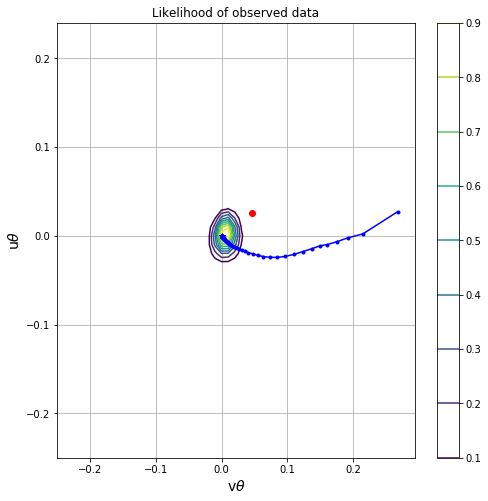

In [104]:
NorLikelihood = np.exp(Loglikelihood - np.max(Loglikelihood)) 
fig_contour, ax = plt.subplots(figsize = (8,8))
uValuemesh, vValuemesh = np.meshgrid(uValue, vValue)
cs3 = plt.contour(uValuemesh, vValuemesh, NorLikelihood, 
                  np.arange(np.min(NorLikelihood), np.max(NorLikelihood), 0.1))
plt.plot(point_2d[:, 0], point_2d[:, 1], marker='.', color = 'b')   # projected trajectories
plt.plot(0, 0, marker='*', color = 'b')                             # final point
plt.plot(true_2d[0], true_2d[1], marker='o', color = 'r')           # true


ax.grid()
ax.set_title('Likelihood of observed data')
# plt.xlabel(r'$u \mathbf{\theta}$', fontsize = 10)
# plt.ylabel(r'$v \mathbf{\theta}$', fontsize = 10)
plt.xlabel(r'v$\theta$', fontsize=14)
plt.ylabel(r'u$\theta$',fontsize=14)
plt.clabel(cs3, inline=1, fontsize=15)
plt.colorbar()
plt.show()

# Check posterior with estimated parameters

In [60]:
para_test =  parameters_new 

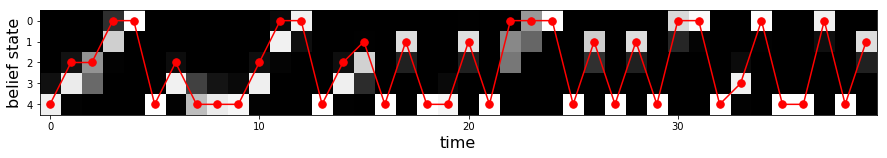

In [197]:
onebox_test = oneboxColMDPder(discount, nq, nr, na, para_test)
ThA_test = onebox_test.ThA
softpolicy_test = onebox_test.softpolicy
TBo_test = onebox_test.Trans_hybrid_obs
OE_TS_test = onebox_test.Obs_emis_trans
pi = np.ones(nq) / nq 
oneHMM_test = HMMoneboxCol(ThA_test, softpolicy_test, TBo_test, OE_TS_test, pi, 3)

alpha_test, scale_test = oneHMM_test.forward_scale(obs)
beta_test = oneHMM_test.backward_scale(obs, scale_test)
gamma_test = oneHMM_test.compute_gamma(alpha_test, beta_test)
xi_test = oneHMM_test.compute_xi(alpha_test, beta_test, obs)
#realxi_test = oneHMM_test.realxi(lat, obs)
showT = 40
fig, ax = plt.subplots(figsize= (15, 15))
plt.imshow(np.flipud(gamma_test[:, 100:showT+100]), interpolation='Nearest', cmap='gray')
plt.plot(nq - 1 - lat[100:showT+100], color = 'r',marker ='.', markersize = 15)
plt.xticks(np.arange(0, showT, 10))
plt.xlabel('time', fontsize = 16)
plt.ylabel('belief state', fontsize = 16)

plt.show()

In [62]:
posterior_ave = np.zeros((nq, nq))
for i in range(nq):
    ind = np.where(lat == i)[0]
    posterior_ave[:, i] = np.sum(gamma_test[:, ind], axis = 1)/np.size(ind)

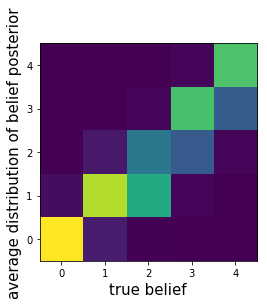

In [185]:
plt.imshow(posterior_ave, origin='lower')
plt.xlabel('true belief', fontsize = 15)
plt.ylabel('average distribution of belief posterior', fontsize = 15)
plt.show()

# Check Hessian

In [176]:
from numpy import linalg as LA

In [152]:
parameters

[0, 0.3, 0.1, 1, 0.6, 4, 0.3, 0.7]

In [181]:
point[-1]

array([0.        , 0.39763288, 0.09625456, 1.        , 0.62414039,
       4.        , 0.25684955, 0.54768758])

In [155]:
perturb = 10 ** -6

In [198]:
paraHessian = np.copy(point[-1])
#paraHessian = np.copy(parameters)

In [199]:
hes = np.zeros((5, 8))

oneboxCold = oneboxColMDPder(discount, nq, nr, na, paraHessian)
oneboxCold1st = np.array(oneboxCold.dQauxdpara_sim(obs, paraHessian))

index = [1,2,4,6,7]
for i in range(5):
    para_perb = np.copy(paraHessian)
    para_perb[index[i]] += perturb
    oneboxCold_perb = oneboxColMDPder(discount, nq, nr, na, para_perb)
        
    oneboxCold1st_pert = np.array(oneboxCold_perb.dQauxdpara_sim(obs, para_perb))
    
    hes[i, :] = (oneboxCold1st_pert - oneboxCold1st) / perturb

In [200]:
hes_para = hes[:, [1,2,4,6,7]]
hes_para

array([[-14137.18564436,   2683.46411758,   7991.04782345,
         -3940.84054278,  -5243.4643294 ],
       [  2598.42636297,  -3107.97076963,  -1426.08769238,
          1207.58159028,   1521.58463607],
       [  7989.91095508,  -1414.94638228,  -6663.86767989,
          2680.28088612,   2899.69648293],
       [ -4284.40216638,   1653.23399415,   2648.67594524,
        -11910.74261442,   -295.58577808],
       [ -5538.36798645,   1499.75676322,   2891.73840429,
          -423.59715735,  -9781.61551757]])

In [201]:
w, v = LA.eig(hes_para)

In [202]:
w

array([-24582.27303277, -10899.16122386,  -6088.87173897,  -1518.08412238,
        -2512.9921079 ])

In [203]:
np.sqrt(-1.0 / w)

array([0.00637807, 0.00957863, 0.01281538, 0.02566564, 0.01994823])

In [204]:
np.sqrt(np.diagonal(-np.linalg.inv(hes_para)))

array([0.01608961, 0.01987682, 0.02163809, 0.00985975, 0.01157307])

In [206]:
paraHessian = np.copy(parameters)

In [207]:
hes = np.zeros((5, 8))

oneboxCold = oneboxColMDPder(discount, nq, nr, na, paraHessian)
oneboxCold1st = np.array(oneboxCold.dQauxdpara_sim(obs, paraHessian))

index = [1,2,4,6,7]
for i in range(5):
    para_perb = np.copy(paraHessian)
    para_perb[index[i]] += perturb
    oneboxCold_perb = oneboxColMDPder(discount, nq, nr, na, para_perb)
        
    oneboxCold1st_pert = np.array(oneboxCold_perb.dQauxdpara_sim(obs, para_perb))
    
    hes[i, :] = (oneboxCold1st_pert - oneboxCold1st) / perturb

In [208]:
hes_para = hes[:, [1,2,4,6,7]]
hes_para

array([[-7481.73079046,  1549.32422447,  5634.31967748, -2545.67567026,
         -540.23985285],
       [ 1541.59351951, -1566.6046238 , -1152.32978715,    56.38867151,
          146.20127331],
       [ 5617.72139918, -1151.19291877, -5168.65839018,  1798.98052011,
         4392.40466221],
       [-3030.89109366,   332.4203135 ,  1772.83254743, -7466.04200685,
        -1834.90556083],
       [-1117.99636215,   273.98527891,  4370.34941569, -1806.02910405,
        -1263.97026179]])

In [209]:
w, v = LA.eig(hes_para)

In [210]:
w

array([-15132.60929391,   2456.03003256,  -5879.80830804,  -3228.77983085,
        -1161.83867284])

In [211]:
np.sqrt(-1.0 / w)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([0.00812911,        nan, 0.01304123, 0.01759871, 0.02933777])